# Importing required libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV,StratifiedKFold

from lightgbm import LGBMRegressor
import sklearn
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

from hyperopt import STATUS_OK 
from hyperopt import hp 
from hyperopt import tpe 
from hyperopt import fmin 
from hyperopt import Trials


In [2]:
train= pd.read_csv("/home/khushboo/Documents/Fractal/week6/train.csv")
test = pd.read_csv("/home/khushboo/Documents/Fractal/week6/test_6hcImfB.csv")

In [3]:
train.columns 

Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Sales'],
      dtype='object')

In [4]:
test.columns

Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric'],
      dtype='object')

We can see that test dataset doesn't contain User_traffic apart from target variables

In [5]:
train.shape

(512087, 11)

In [6]:
test.shape 

(36000, 9)

In [7]:
train.ID.nunique()

512087

In [8]:
train.nunique()

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       196
Sales                    544
dtype: int64

* ID is not affecting target value, we can drop it.
* ID is unique number and it is okay to be integer.

In [9]:
train= train.drop(['ID'], axis=1)

In [10]:
test= test.drop(['ID'], axis=1)

In [11]:
train.Sales.describe() 

count    512087.000000
mean        120.826924
std          54.355258
min           0.000000
25%          84.000000
50%         111.000000
75%         146.000000
max         682.000000
Name: Sales, dtype: float64

#### Check if missing values are available

In [12]:
train.isna().sum()


Day_No                   0
Course_ID                0
Course_Domain            0
Course_Type              0
Short_Promotion          0
Public_Holiday           0
Long_Promotion           0
User_Traffic             0
Competition_Metric    1764
Sales                    0
dtype: int64

#### Understand Categorical ratio in variable 

In [13]:
train['Course_Domain'].value_counts()

Development             264295
Software Marketing      166172
Finance & Accounting     77210
Business                  4410
Name: Course_Domain, dtype: int64

In [14]:
train['Course_Type'].value_counts()

Course     262747
Program    247576
Degree       1764
Name: Course_Type, dtype: int64

In [15]:
train['Course_ID'].value_counts()

256    882
152    882
148    882
149    882
405    882
      ... 
432    698
435    698
436    698
181    698
511    698
Name: Course_ID, Length: 600, dtype: int64

Datatypes

In [16]:
train.dtypes

Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object


* Day_no is also integer
* Course_Domain, Course_Type,course ID, short promotion, public_holiday and long promotion suppose to be categorical

In [17]:
# data.shape

# Exploratory Data Analysis

(array([6.33870e+04, 2.92106e+05, 1.19724e+05, 2.72570e+04, 7.27300e+03,
        1.84000e+03, 3.90000e+02, 8.60000e+01, 2.00000e+01, 4.00000e+00]),
 array([  0. ,  68.2, 136.4, 204.6, 272.8, 341. , 409.2, 477.4, 545.6,
        613.8, 682. ]),
 <BarContainer object of 10 artists>)

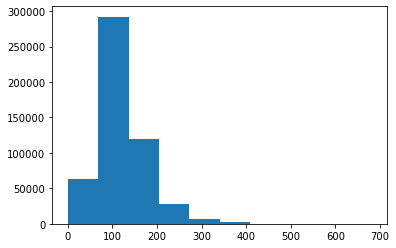

In [18]:
# data=data1
plt.hist(train["Sales"])

### Univariate Analysis 

* Numerical variables

In [19]:
# custom function for easy and efficient analysis of numerical univariate

def UVA_numeric(data, var_group):
  ''' 
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
#     print(data[i])
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

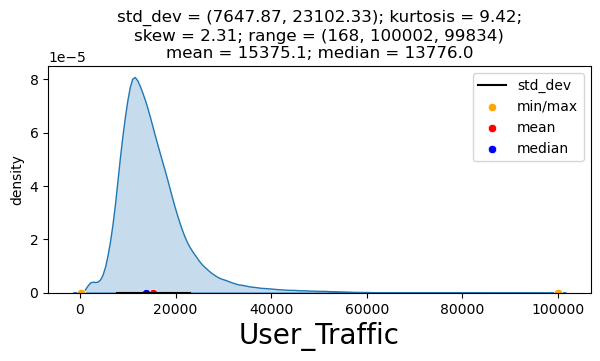

In [20]:
UVA_numeric(train,['User_Traffic'])

In [21]:
group=['Course_ID','Day_No','Competition_Metric']

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

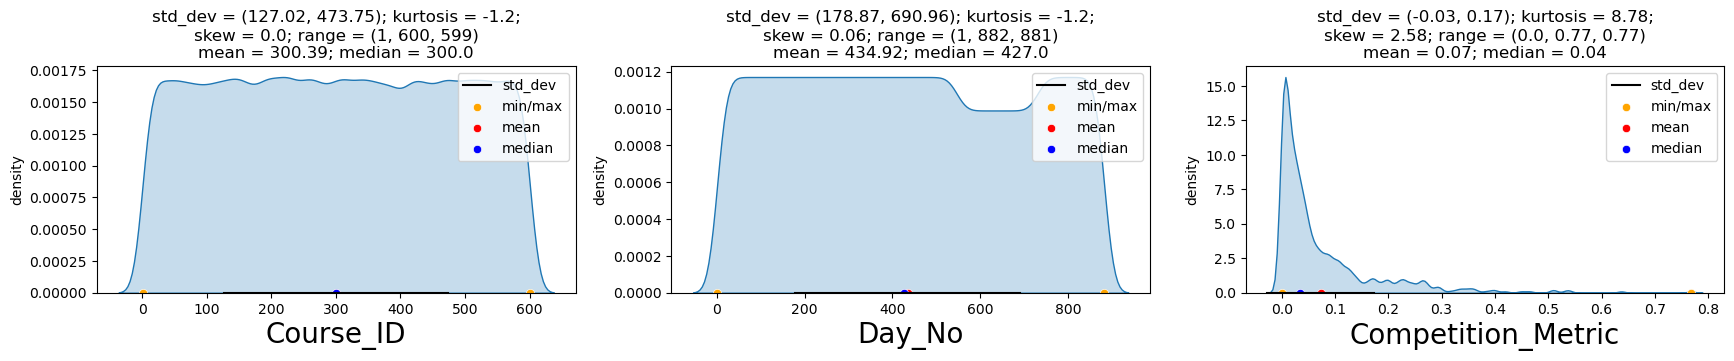

In [22]:
UVA_numeric(train,group)

* We can colclude from plot that User traffic is positively skewed or outliers are present
* we can apply log transformation on it 


/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

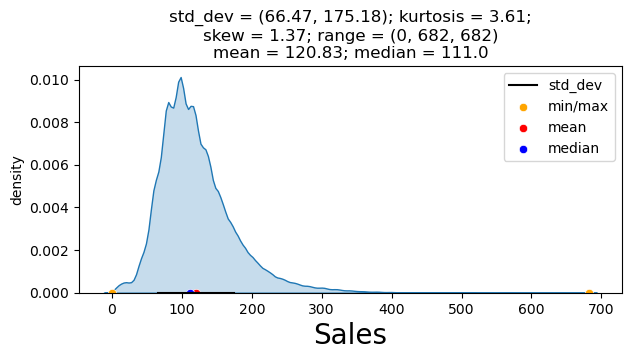

In [23]:
UVA_numeric(train,['Sales'])

* Since kutosis is > 3, we can conclude that Distribution is longer, has Many Outliers

<AxesSubplot:>

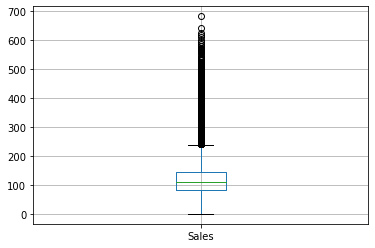

In [24]:
train[['Sales']].boxplot()

<AxesSubplot:>

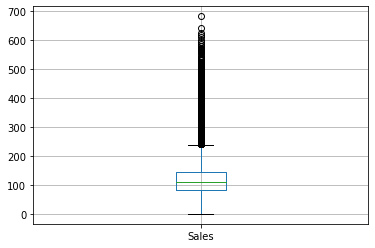

In [25]:
train[['Sales']].boxplot()

<AxesSubplot:>

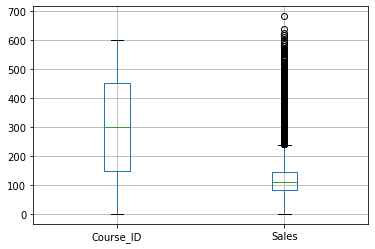

In [26]:
train[['Course_ID','Sales']].boxplot()

* Categorical variables

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Long_Promotion', ylabel='count'>

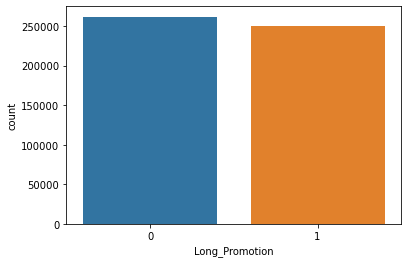

In [27]:
sns.countplot(train['Long_Promotion'])

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Short_Promotion', ylabel='count'>

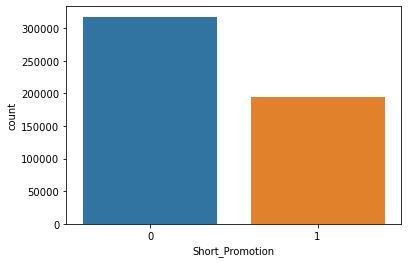

In [28]:
sns.countplot(train['Short_Promotion'])

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Course_Domain', ylabel='count'>

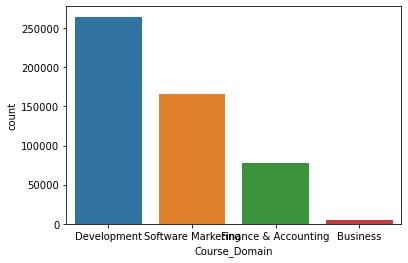

In [29]:
sns.countplot(train['Course_Domain'])

In [30]:
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(norm_count, norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 20)
    plt.ylabel('{}'.format(i), fontsize = 20)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


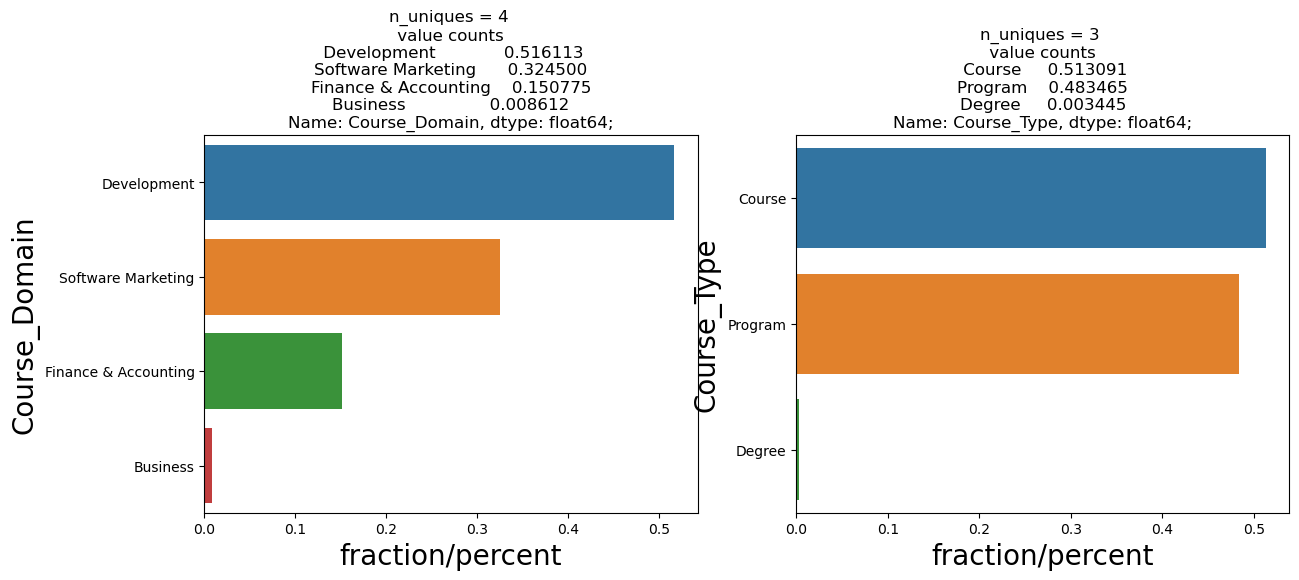

In [31]:
UVA_category(train, ['Course_Domain', 'Course_Type'])

* We can see Business make less sales, so to increase the sales marketing or sales team should do something.
* We can also conclude that people are not interested in degree course type.

obviously, sales will be less during public holiday which can be verified from dataset as well.

### Bivariate Analysis

* Numerical-Numerical

In [32]:
# isolating numerical datatypes
numerical = train.select_dtypes(include=['int64','float64','Int64'])[:]
numerical.dtypes

Day_No                  int64
Course_ID               int64
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object

<AxesSubplot:>

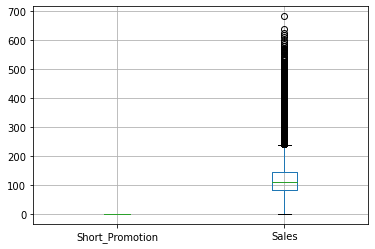

In [33]:
train[['Short_Promotion','Sales']].boxplot()

Normalization can be performed in non-decision based algo

<AxesSubplot:>

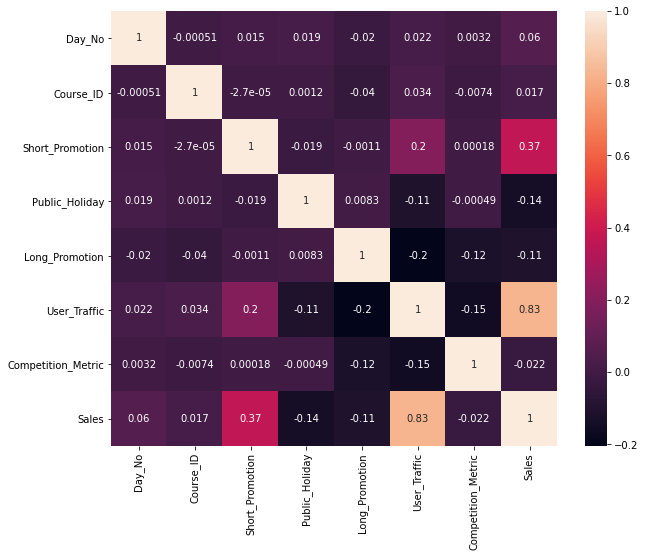

In [34]:
# Lets find the correlation
plt.subplots(figsize=(10,8))
sns.heatmap(train.corr(), annot= True)

* User traffic and Sales are highly correlated. In predicting sales it is a important feature
* Competition metric is an important feature 

But we can see in test set user traffic is not given, so we can use feature engineering by predicting user traffic first or drop it 

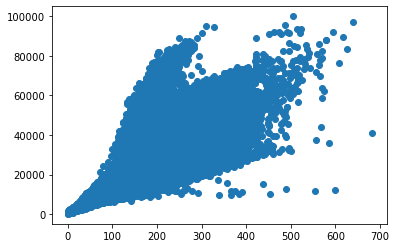

In [35]:
plt.scatter(train['Sales'], train['User_Traffic'])

In [36]:
train.corr().unstack().sort_values().drop_duplicates()

User_Traffic        Long_Promotion       -0.204289
Competition_Metric  User_Traffic         -0.148775
Public_Holiday      Sales                -0.135052
Long_Promotion      Competition_Metric   -0.119382
Sales               Long_Promotion       -0.109455
Public_Holiday      User_Traffic         -0.108305
Long_Promotion      Course_ID            -0.039605
Sales               Competition_Metric   -0.022085
Day_No              Long_Promotion       -0.020204
Short_Promotion     Public_Holiday       -0.018770
Competition_Metric  Course_ID            -0.007385
Short_Promotion     Long_Promotion       -0.001149
Course_ID           Day_No               -0.000506
Competition_Metric  Public_Holiday       -0.000491
Course_ID           Short_Promotion      -0.000027
Competition_Metric  Short_Promotion       0.000182
Public_Holiday      Course_ID             0.001242
Day_No              Competition_Metric    0.003229
Public_Holiday      Long_Promotion        0.008319
Day_No              Short_Promo

* Numerical - Categorical

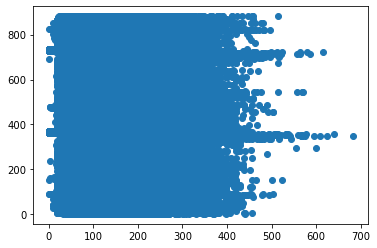

In [37]:
# data1.shar
plt.scatter(train['Sales'], train['Day_No'])

We can conclude that Day_no is not a good estimator 

In [38]:
train.dtypes

Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object

How Course_Domain is influenciung Sales?
How Course_type is influencing Sales ?
affect of promotions on sales ?
public holiday leads to decrement in sales ?

In [39]:
import seaborn as sns


<AxesSubplot:xlabel='Course_Domain', ylabel='Sales'>

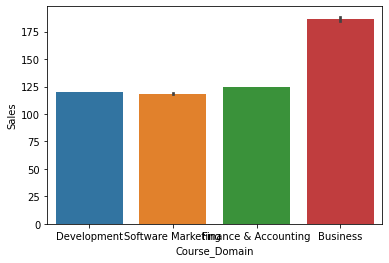

In [40]:
sns.barplot(x="Course_Domain", y="Sales", data=train[:])

<AxesSubplot:xlabel='Course_Type', ylabel='Sales'>

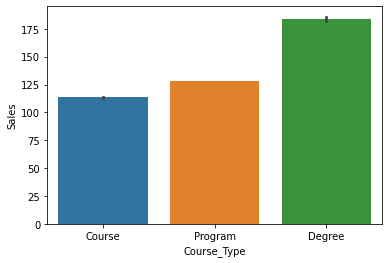

In [41]:
sns.barplot(x="Course_Type", y="Sales", data=train[:])

In [42]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import norm
  ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
  z = (X1 - X2)/ovr_sigma
  pval = 2*(1 - norm.cdf(abs(z)))
  return pval

In [43]:
def TwoSampT(X1, X2, sd1, sd2, n1, n2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import t as t_dist
  ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
  t = (X1 - X2)/ovr_sd
  df = n1+n2-2
  pval = 2*(1 - t_dist.cdf(abs(t),df))
  return pval

In [44]:
def Bivariate_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][(data[cat]==category)][:]
  x2 = data[cont][~(data[cat]==category)][:]
#   print(x1)
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.mean()
  
  #calculating p-values
  t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')
  

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


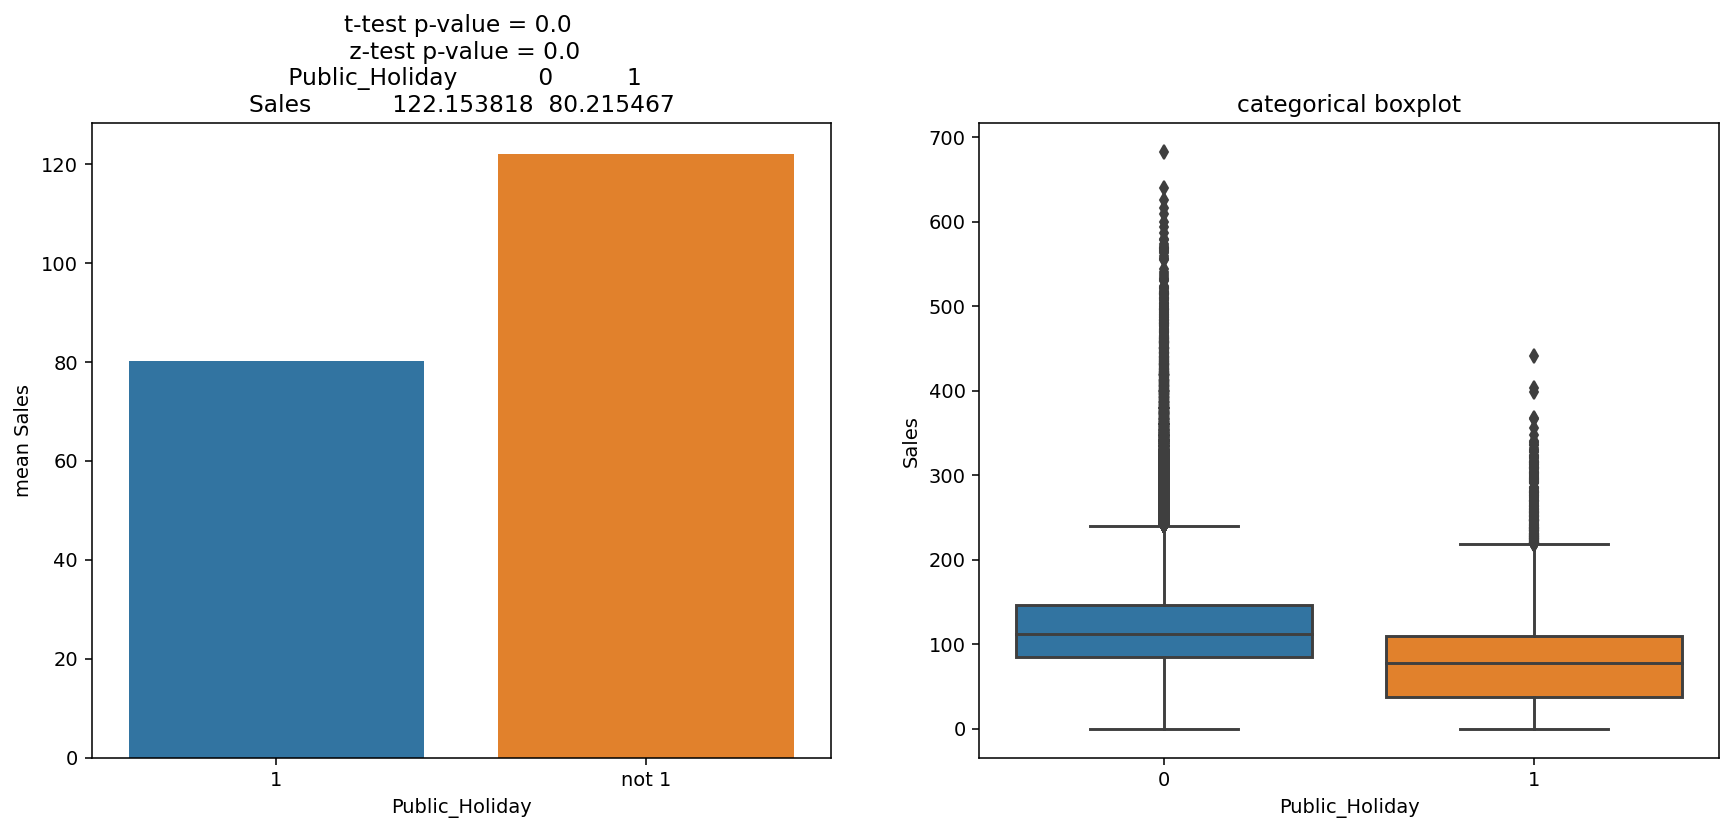

In [45]:
Bivariate_cont_cat(train, "Sales", "Public_Holiday", 1)

We can safely reject the hypothesis that public holiday leads to increase in sales 

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


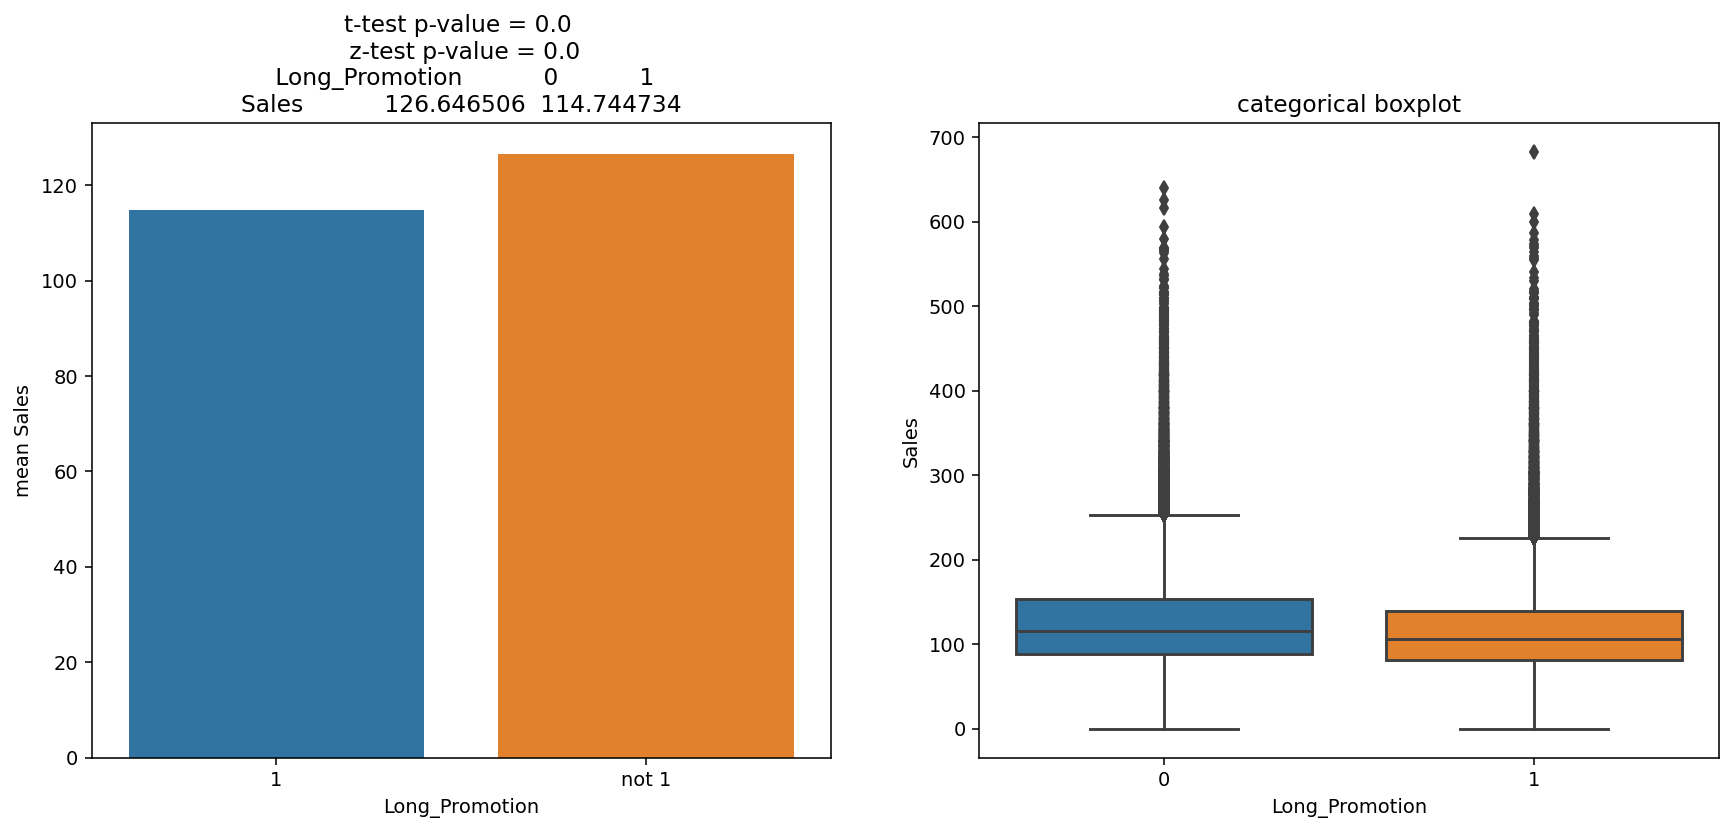

In [46]:
Bivariate_cont_cat(train, "Sales", "Long_Promotion", 1)

We can safely reject the hypothesis that long promotion leads to decrease in sales 

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


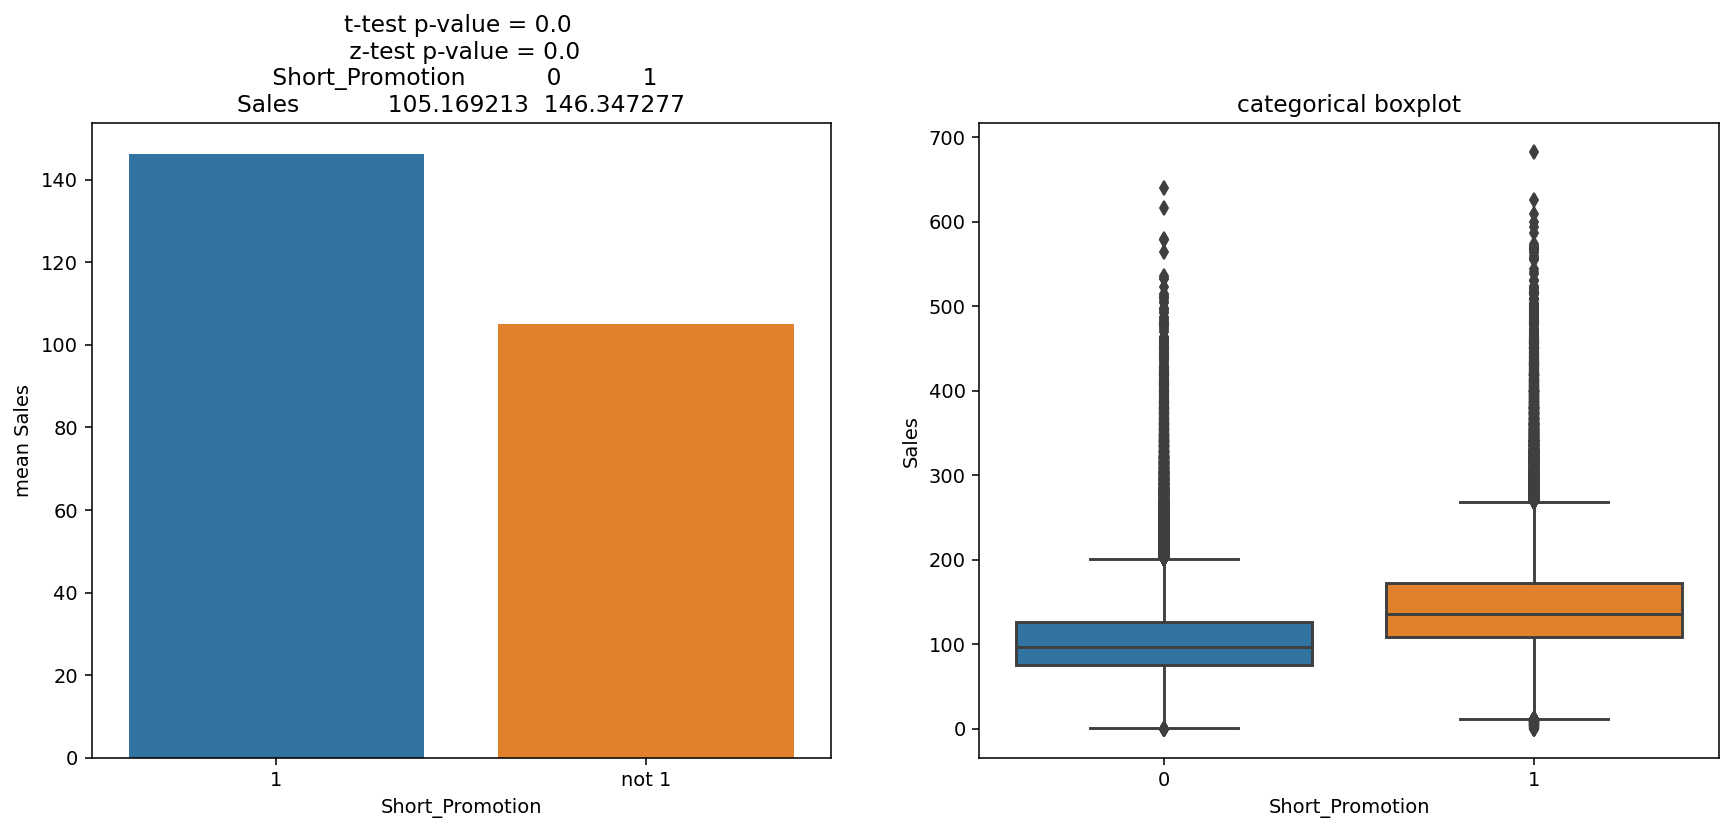

In [47]:
Bivariate_cont_cat(train, "Sales", "Short_Promotion", 1)

# Outliers

<AxesSubplot:xlabel='Course_Domain', ylabel='Sales'>

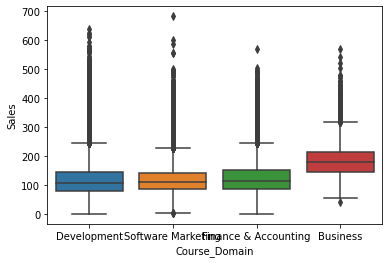

In [48]:
sns.boxplot(x='Course_Domain',y='Sales',data=train)

Boxplot shows very similar distribution with outliers on the lower end

<AxesSubplot:xlabel='Day_No'>

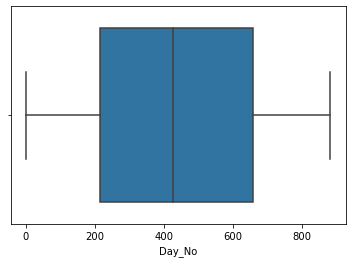

In [49]:
sns.boxplot(x='Day_No',data=train)

# Pre-Processing

### Creating new features

In [50]:
# train['binned'] = pd.cut(train['Competition_Metric'],bins=5, labels=['very_low','low','medium','high','very_high'])

In [51]:
def day_to_date(dataset):
    start = date(2018,12,31)
    dataset['Date'] = dataset['Day_No'].apply(lambda x: start + timedelta(x)) 

def day_month_year(dataset): 
    dataset['Day'] = dataset['Date'].apply(lambda x: x.day)
    dataset['Month'] = dataset['Date'].apply(lambda x: x.month)
    dataset['Year'] = dataset['Date'].apply(lambda x: x.year)
    dataset['Day_of_week']= dataset['Date'].apply(lambda x: x.weekday())

In [52]:
day_to_date(train)
day_month_year(train)
day_to_date(test)
day_month_year(test)

### Understanding created variables

<AxesSubplot:xlabel='Day_of_week', ylabel='Sales'>

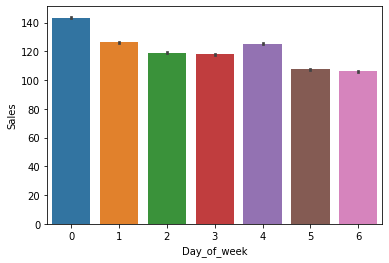

In [53]:
sns.barplot(x="Day_of_week", y="Sales", data=train)

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

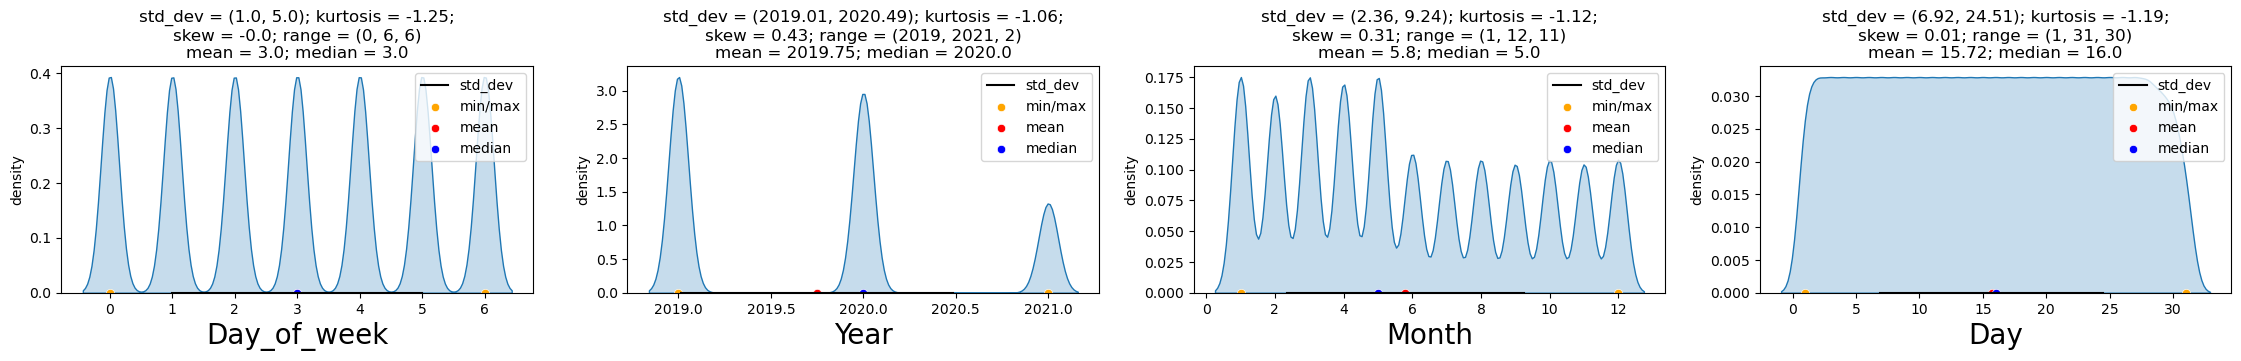

In [54]:
UVA_numeric(train, ["Day_of_week", 'Year',"Month","Day"])

<AxesSubplot:>

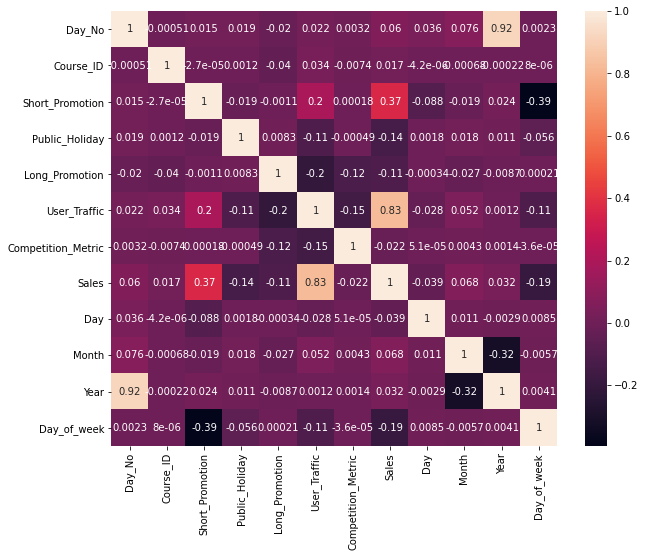

In [55]:
# Lets find the correlation
plt.subplots(figsize=(10,8))
sns.heatmap(train.corr(), annot= True)

In [56]:
train

,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,Date,Day,Month,Year,Day_of_week
0,1,1,Development,Course,0,1,1,11004,0.007,81,2019-01-01,1,1,2019,1
1,2,1,Development,Course,0,0,1,13650,0.007,79,2019-01-02,2,1,2019,2
2,3,1,Development,Course,0,0,1,11655,0.007,75,2019-01-03,3,1,2019,3
3,4,1,Development,Course,0,0,1,12054,0.007,80,2019-01-04,4,1,2019,4
4,5,1,Development,Course,0,0,1,6804,0.007,41,2019-01-05,5,1,2019,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512082,878,600,Software Marketing,Program,0,0,1,8904,0.070,114,2021-05-27,27,5,2021,3
512083,879,600,Software Marketing,Program,0,0,1,10542,0.070,145,2021-05-28,28,5,2021,4
512084,880,600,Software Marketing,Program,0,0,1,13671,0.070,167,2021-05-29,29,5,2021,5
512085,881,600,Software Marketing,Program,0,0,1,8904,0.070,107,2021-05-30,30,5,2021,6


Since test doesnt contain User Traffic, we are removing it

In [57]:
train.drop('User_Traffic',axis =1, inplace = True)

In [58]:
train.shape

(512087, 14)

In [59]:
test.shape 

(36000, 13)

In [60]:
# merge train and test
df = train.append(test)

In [61]:
df.isna().sum()

Day_No                    0
Course_ID                 0
Course_Domain             0
Course_Type               0
Short_Promotion           0
Public_Holiday            0
Long_Promotion            0
Competition_Metric     1884
Sales                 36000
Date                      0
Day                       0
Month                     0
Year                      0
Day_of_week               0
dtype: int64

#### Replacing missing values with median 

In [62]:
df['Competition_Metric'].fillna(df['Competition_Metric'].median(), inplace = True)

#### Converting categorical to integer 

In [63]:
df1=pd.get_dummies(df,columns=['Course_Domain','Course_Type','Day_of_week'],drop_first=True)

In [64]:
df1.dtypes

Day_No                                  int64
Course_ID                               int64
Short_Promotion                         int64
Public_Holiday                          int64
Long_Promotion                          int64
Competition_Metric                    float64
Sales                                 float64
Date                                   object
Day                                     int64
Month                                   int64
Year                                    int64
Course_Domain_Development               uint8
Course_Domain_Finance & Accounting      uint8
Course_Domain_Software Marketing        uint8
Course_Type_Degree                      uint8
Course_Type_Program                     uint8
Day_of_week_1                           uint8
Day_of_week_2                           uint8
Day_of_week_3                           uint8
Day_of_week_4                           uint8
Day_of_week_5                           uint8
Day_of_week_6                     

In [65]:
df1.shape

(548087, 22)

In [66]:
df1.columns 

Index(['Day_No', 'Course_ID', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion', 'Competition_Metric', 'Sales', 'Date', 'Day', 'Month',
       'Year', 'Course_Domain_Development',
       'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program', 'Day_of_week_1', 'Day_of_week_2',
       'Day_of_week_3', 'Day_of_week_4', 'Day_of_week_5', 'Day_of_week_6'],
      dtype='object')

In [67]:
# dropping columns 
df1.drop(['Day_No','Date'],axis = 1,inplace = True)

### Generating train, test from df1

In [68]:

train1= df1[df1['Sales'].isnull()!= True]
test1= df1[df1['Sales'].isnull()== True].drop(['Sales'], axis=1)
print(train1.shape)
print(test1.shape)

(512087, 20)
(36000, 19)


In [69]:
X_train = train1.drop('Sales',axis = 1)
Y_train = train.Sales
X_test = test1

In [70]:
print(X_train.columns)
print(Y_train)
print(X_test.columns)


Index(['Course_ID', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Day', 'Month', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program', 'Day_of_week_1', 'Day_of_week_2',
       'Day_of_week_3', 'Day_of_week_4', 'Day_of_week_5', 'Day_of_week_6'],
      dtype='object')
0          81
1          79
2          75
3          80
4          41
         ... 
512082    114
512083    145
512084    167
512085    107
512086    152
Name: Sales, Length: 512087, dtype: int64
Index(['Course_ID', 'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
       'Competition_Metric', 'Day', 'Month', 'Year',
       'Course_Domain_Development', 'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Degree',
       'Course_Type_Program', 'Day_of_week_1', 'Day_of_week_2',
       'Day_of_week_3', 'Day_of_week_4', 'Da

# Modelling

## just checking 

TRAIN TEST SPLIT

In [71]:
train_x,val_x,train_y,val_y = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 890)

In [72]:
lgb_train = lgb.Dataset(train_x, train_y)
lgb_val = lgb.Dataset(val_x, val_y)

In [73]:
N_FOLDS = 5

In [74]:
def rmsle(preds, lgb_train): 
    eval_name = 'rmsle' 
    eval_result = np.sqrt(mean_squared_log_error(preds, lgb_train.get_label())) 
    return (eval_name, eval_result*1000, False)

In [75]:
def objective(params, n_folds = N_FOLDS): 
    cv_results = lgb.cv(params, lgb_train, num_boost_round = 1000, nfold = 5, feval = rmsle, early_stopping_rounds = 10, seed = 50) 
    best_score = min(cv_results['rmsle-mean']) 
    return {'loss': best_score, 'params': params, 'status': STATUS_OK}

In [76]:
space = { 'task': hp.choice('task', ['train']), 'objective': hp.choice('objective', ['gamma']), 'metric' : hp.choice('metric', ['None']), 'boosting': hp.choice('boosting', ['gbdt']), 'learning_rate': hp.loguniform('learning_rate',np.log(0.003), np.log(0.5)), 'num_leaves': hp.choice('num_leaves', range(2, 100, 5)), 'max_depth': hp.choice('max_depth', range(1, 30, 5)), 'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1.0), 'bagging_freq': hp.choice('bagging_freq', range(1, 10, 1)), 'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0), 'max_bin': hp.choice('max_bin', range(200, 256, 5)), 'min_data_in_leaf': hp.choice('min_data_in_leaf', range(10, 1000, 1)), 'subsample': hp.uniform('subsample', 0.1, 1.0), 'bagging_seed': hp.choice('bagging_seed', range(1, 10, 1)), 'feature_fraction_seed': hp.choice('feature_fraction_seed', range(1, 10, 1)), }

In [77]:
evals_result = {} 
params = {
        'task': 'train',
        'objective': 'gamma',
        'metric' : 'None',
        'boosting': 'gbdt',
        'learning_rate': 0.03,
        'num_leaves': 100,
        'bagging_fraction': 0.85,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'n_estimators': 1000,
    }
def rmsle(preds, lgb_train):
    eval_name = "rmsle"
    eval_result = np.sqrt(mean_squared_log_error(preds, lgb_train.get_label()))
    return (eval_name, eval_result*1000, False)


cv_results = lgb.cv(params, lgb_train, num_boost_round = 1000, nfold = 5, feval = rmsle, early_stopping_rounds = 10, verbose_eval = 100, seed = 50)

lgbm_model = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, feval = rmsle,  evals_result = evals_result, verbose_eval = 100)

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/lightgbm/engine.py:527: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 327735, number of used features: 19
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 327735, number of used features: 19
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number o

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 409669, number of used features: 19
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4.794179
[100]	valid_0's rmsle: 258.495
[200]	valid_0's rmsle: 195.038
[300]	valid_0's rmsle: 168.679
[400]	valid_0's rmsle: 154.919
[500]	valid_0's rmsle: 145.838
[600]	valid_0's rmsle: 139.968
[700]	valid_0's rmsle: 135.659
[800]	valid_0's rmsle: 132.301
[900]	valid_0's rmsle: 129.346
[1000]	valid_0's rmsle: 127.146


In [78]:
predictions = lgbm_model.predict(X_test)

In [79]:
predictions

array([121.59882397, 123.36793372, 107.96853882, ..., 127.00411064,
       157.17087667, 152.41945317])

In [80]:
sample= pd.DataFrame(predictions)

In [81]:
test_data = pd.read_csv("/home/khushboo/Documents/Fractal/week6/test_6hcImfB.csv")

In [82]:
sample['ID']= test_data["ID"]
sample=sample.rename(columns={0: "Sales_by_LightGBM"})
sample["Sales_by_LightGBM"] = sample["Sales_by_LightGBM"].apply(np.ceil)

In [83]:
len(predictions)

36000

In [84]:
def rmsle1000(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(y_true, np.ceil(y_pred)))*1000
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2))) *1000

In [85]:
#xgb
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)

X_train = train1.drop('Sales',axis = 1)
Y_train = train.Sales
Y_train = Y_train
X_test = test1

cv_score =[]
i=1
for train_index,test_index in kf.split(X_train, Y_train):
    print('Fold no. = ', i)
    
    x_train, x_test = X_train.loc[train_index], X_train.loc[test_index]
    y_train, y_test = Y_train.loc[train_index], Y_train.loc[test_index]
    
    #model
    xgb = XGBRegressor(n_estimators= 500)
    xgb.fit(x_train, y_train)
    y_pred= xgb.predict(x_test)
    score = rmsle1000(y_test, y_pred)
    print('RMSLE score:',score)
    cv_score.append(score)    
    
    i+=1

/home/khushboo/miniconda3/envs/fractal/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Fold no. =  1


<ipython-input-84-329c0079301e>:3: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2))) *1000


RMSLE score: 140.33958568896136
Fold no. =  2
RMSLE score: 141.73454999509406
Fold no. =  3
RMSLE score: 143.61351649952536
Fold no. =  4
RMSLE score: 141.97065229473972
Fold no. =  5
RMSLE score: 143.4609347918881


In [86]:
cv_score

[140.33958568896136,
 141.73454999509406,
 143.61351649952536,
 141.97065229473972,
 143.4609347918881]

In [87]:
xgb.feature_importances_

array([0.07290978, 0.14651874, 0.03904509, 0.09192132, 0.07342734,
       0.02235936, 0.01915625, 0.01002802, 0.07157941, 0.04016996,
       0.04685441, 0.103359  , 0.08020809, 0.04752225, 0.03494979,
       0.02187755, 0.02823355, 0.02237553, 0.02750451], dtype=float32)

In [88]:
xgb = XGBRegressor(n_estimators= 500)
xgb.fit(X_train,Y_train)
xgb_preds = xgb.predict(X_test)
# xgb_preds= np.expm1(xgb_preds)

In [89]:
sample['Sales_by_XGB']= pd.DataFrame(xgb_preds)

In [90]:
# for submission
lgbm = LGBMRegressor(n_estimators= 500)
lgbm.fit(X_train, Y_train)
lgbm_preds = lgbm.predict(X_test)

In [91]:
sample['Sales_by_lgbm']= pd.DataFrame(lgbm_preds)

In [92]:
sample.head(20)

,Sales_by_LightGBM,ID,Sales_by_XGB,Sales_by_lgbm
0,122.0,883,125.857880,135.235594
1,124.0,884,123.428200,127.921896
2,108.0,885,102.850250,110.460706
3,105.0,886,96.965851,110.983678
4,62.0,887,59.508316,66.926066
5,88.0,888,97.935097,89.625926
6,82.0,889,88.175743,85.581158
7,81.0,890,89.369225,86.216645
8,88.0,891,99.878532,90.428889
9,79.0,892,82.378235,79.738490


### Final Submission made 

In [93]:
sample=sample.rename(columns={"Sales":"Sales_by_LightGBM"})

In [94]:
df3= sample[['ID','Sales_by_LightGBM']]

In [95]:
df3=df3.rename(columns={'Sales_by_LightGBM': "Sales"})

In [96]:
# df3.to_csv('hackathon_final_submission_127.csv',index=False)